In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pydicom
import os
import numpy
from matplotlib import pyplot, cm
from fastai.vision import *
import fastai

from os import walk 

## Prepare Data

In [3]:
# function to open dcm images
def open_dcm_image(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        dicom_file = pydicom.dcmread(str(fn))
        arr = dicom_file.pixel_array.copy() 
        arr = arr * int(dicom_file.RescaleSlope) + int(dicom_file.RescaleIntercept) 
        level = 40; window = 80
        arr = np.clip(arr, level - window // 2, level + window // 2)
        x = PIL.Image.fromarray(arr).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

In [4]:
fastai.vision.data.open_image = open_dcm_image    

In [5]:
dirpath = "../input/rsna-intracranial-hemorrhage-detection/"
!ls ../input/rsna-intracranial-hemorrhage-detection

stage_1_sample_submission.csv  stage_1_train.csv
stage_1_test_images	       stage_1_train_images


In [6]:
df_train = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv')
df_train['fn'] = df_train.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')
df_train['label'] = df_train.ID.apply(lambda x: x.split('_')[-1])
df_train.head()
# remove corrupted file
df_train = df_train[df_train.fn != 'ID_000039fa0.dcm']
df_train = df_train[df_train.fn != 'ID_6431af929.dcm']

In [7]:
print(df_train.shape)
df_train.drop_duplicates(inplace = True)
print(df_train.shape)

(4045560, 4)
(4045536, 4)


In [8]:
df_train.head(2)

,ID,Label,fn,label
0,ID_63eb1e259_epidural,0,ID_63eb1e259.dcm,epidural
1,ID_63eb1e259_intraparenchymal,0,ID_63eb1e259.dcm,intraparenchymal


In [9]:
pivot = df_train.pivot(index='fn', columns='label', values='Label')
pivot.reset_index(inplace=True)
pivot['any'].value_counts()

0    577153
1     97103
Name: any, dtype: int64

In [10]:
mask = pivot['any'] == 0
pivot['None'] = ""
pivot.loc[mask, 'None'] = 'None'

label_cols = ['any', 'None'] 
for col in label_cols:
    print(col, end= ", ")
    pivot[col] = pivot[col].replace({0:"", 1:col})
    
pivot['MultiLabel'] = pivot[label_cols].apply(lambda x: " ".join((' '.join(x)).split()), axis=1)

any, None, 

In [11]:
pivot.tail(2)

label,fn,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,None,MultiLabel
674254,ID_ffff922b9.dcm,any,0,0,1,0,0,,any
674255,ID_fffff9393.dcm,,0,0,0,0,0,None,None


# Create DataBunch for fastai vision 

In [12]:
tfms = get_transforms(do_flip = False) # we can add more augumentaion tricks here 

In [13]:
pivot.MultiLabel.unique()

array(['None', 'any'], dtype=object)

In [14]:
path = "../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/"
np.random.seed(42)
data_train = (ImageList
.from_df(path=path,df= pivot[['fn', 'MultiLabel']])
.split_by_rand_pct(valid_pct=0.2)   #20% validation 
.label_from_df(cols=1, label_delim = ' ')
.transform(size=(128,128))
.databunch()
.normalize(imagenet_stats))

## Train Model

In [15]:
path = '/output/'
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [16]:
learn = cnn_learner( data_train, models.resnet34, path = path, metrics = acc_02 ) 
#we can try other pretrained models later

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


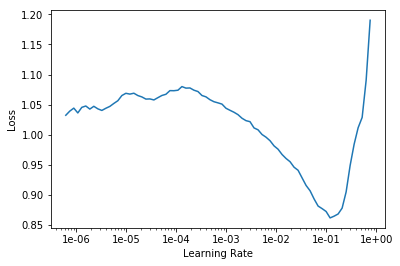

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-1
learn.freeze()  
learn.fit_one_cycle(2, slice(lr)) #2 epochs to save time 

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.284941,0.222423,0.885014,1:42:29
1,0.189661,0.188166,0.911113,1:41:11


In [19]:
learn.save('stage-1')

In [20]:
learn.load('stage-1')    

Learner(data=ImageDataBunch;

Train: LabelList (539405 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
None,None,None,None,None
Path: ../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images;

Valid: LabelList (134851 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
None,None,None,None,None
Path: ../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

## Evaluate Model

In [21]:
# interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
# interp.plot_top_losses(9)
# interp.plot_confusion_matrix() 

In [22]:
data_classes = learn.data.classes
learn.data = data_train
y_predict, targets = learn.get_preds(ds_type=DatasetType.Valid) # on validation set 

In [23]:
y_val= torch.Tensor.numpy(targets)
y_pred= torch.Tensor.numpy(y_predict)

In [24]:
y_val=np.argmax(y_val,1 ) 
y_pred=np.argmax(y_pred,1 )  

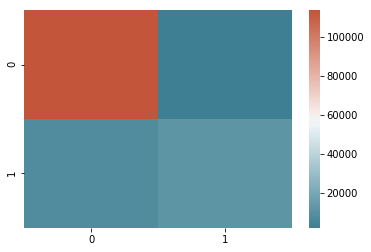

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.heatmap(confusion_matrix(y_val, y_pred), cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [26]:
confusion_matrix(y_val, y_pred) 

array([[113398,   1953],
       [  7882,  11618]])

In [27]:
import pandas as pd
report = classification_report(y_val, y_pred,output_dict=True) 
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.935010,0.983069,0.958437,115351.000000
1,0.856090,0.595795,0.702610,19500.000000
accuracy,0.927068,0.927068,0.927068,0.927068
macro avg,0.895550,0.789432,0.830523,134851.000000
weighted avg,0.923598,0.927068,0.921444,134851.000000


Next steps 

Grid search and more epochs